# Crafting a first data set. 
Things that need to be done: 
- find a set of satellite images that is tagged with locations
- find a granular poverty data set taht includes locations taht can be mapped to the images
- join the datasets 

## Packages

In [1]:
import numpy as np
import scipy as sp
import scipy.stats as sts
import matplotlib.pyplot as plt
import time

from collections import defaultdict
from glob import glob
import random as rd
import pylab as pl
import pandas as pd
import re
from sklearn import decomposition
from sklearn import pipeline


from PIL import Image
import PIL.ImageOps

from skimage import io, color
import matplotlib.image as mpimg
from skimage.transform import resize

from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split, cross_val_score,  GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import classification_report, mean_squared_error

import seaborn as sns
from sklearn.metrics import confusion_matrix

import ntpath
import geopandas as gpd
import geoplot
from shapely.geometry import Point, Polygon
from fiona.crs import from_epsg
import pygeos
import math


/Users/johannes/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


## Import and transform images

In [2]:
# set the random seed for reproducibility
rd.seed(3)

In [3]:
#data_size = int(input("Please input an integer (maybe like 300)"))


In [4]:
#get all the pathlinks to the images
raw_images_links = glob("image_data/malawi_archive/images/*")

In [5]:
#transform the images into arrays
malawi_arrays = [np.array(Image.open(file_name)) for file_name in raw_images_links]
malawi_arrays[0].shape

(256, 256, 4)

In [21]:
#test for identity:
def is_arr_in_list(myarr, list_arrays):
    return next((True for elem in list_arrays if elem is myarr), False)

Lynn's proposed idea: 
- train full_pca with all images
- filter the images
- reverse transform
- train_test_split 
- continue. 

In [39]:
## New try
malawi_unique = []
unique_indices = []
for id, file_name in enumerate(raw_images_links):
    im_array = np.array(Image.open(file_name))

    if id == 0:
        malawi_unique.append(im_array)
        unique_indices.append(id)

    if is_arr_in_list(im_array, malawi_unique) == False:
        malawi_unique.append(im_array)
        unique_indices.append(id)

In [38]:
#is_arr_in_list(malawi_unique[1], [malawi_unique[302], malawi_unique[302]])

np.any(np.all(malawi_transform[1] == malawi_transform))

False

In [36]:
#flatten the data and resize if necessary

#resize the data and flatten it
def transform(dataset):
    new_list = []
    for i in range(len(dataset)):
        #resize the image
        temp2 = resize(dataset[i], (256, 256), Image.NEAREST)
        
        #flatten it
        new_list.append(temp2.flatten())

    return new_list

#do this for malawi
malawi_transform = transform(malawi_arrays)

In [43]:
n_samples = 50
pca_filter = PCA(n_components=20)
pca_filter.fit(rd.sample(malawi_transform, n_samples))
print(f"Completed training the PCA for filtering with {n_samples} with var expl: {round(np.cumsum(pca_filter.explained_variance_ratio_)[20]*100)}%")
malawi_pca_filter = pca_filter.transform(malawi_transform)

Completed training the PCA for filtering with var expl: [0.56667132 0.64801081 0.7118857  0.76046235 0.77992847 0.79849071
 0.81431686 0.82769986 0.83957073 0.85038035 0.86095692 0.87036959
 0.87927507 0.88734506 0.89533109 0.9028809  0.91028512 0.91665556
 0.92229252 0.92787219]


In [51]:
malawi_unique, unique_indices = np.unique(malawi_pca_filter, axis= 0, return_index= True)

In [58]:
malawi_filtered = pca_filter.inverse_transform(malawi_unique)

(12700, 20)

In [ ]:
#scale the data using StandardScaler
#StandarScaler normalies the images by subtracting the mean and dividing by the unit variance. 
def return_scaled(input_array):
    scaler = StandardScaler(copy=False)
    scaler.fit(rd.sample(input_array,1000))
    data_set = scaler.fit_transform(input_array)

    return data_set

In [ ]:
"""stages = []
assemblerInputs = malawi_transform
assemblerInputs = [column for column in assemblerInputs if column not in columns_to_remove_from_assembler]
#add vector assembler
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features_nonscaled")
stages += [assembler]

col_scaler = StandardScaler(inputCol='features_nonscaled', outputCol='features',withStd=True, withMean=False)
stages += [col_scaler]

pipeline = Pipeline(stages = stages)
assemblerModel = pipeline.fit(df)"""

'stages = []\nassemblerInputs = malawi_transform\nassemblerInputs = [column for column in assemblerInputs if column not in columns_to_remove_from_assembler]\n#add vector assembler\nassembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features_nonscaled")\nstages += [assembler]\n\ncol_scaler = StandardScaler(inputCol=\'features_nonscaled\', outputCol=\'features\',withStd=True, withMean=False)\nstages += [col_scaler]\n\npipeline = Pipeline(stages = stages)\nassemblerModel = pipeline.fit(df)'

## Merging the image data with the outcome data

In [59]:
#load outcome data
outcome_geodf = gpd.read_file("outcome_data/ml_gdf.shp")

In [60]:
#have a look 
outcome_geodf.head()

,DHSID,DHSCLUST,LATNUM,LONGNUM,hv271,geometry
0,MW201500000001,1.0,-13.360652,33.923942,221426,POINT (33.92394 -13.36065)
1,MW201500000001,1.0,-13.360652,33.923942,182618,POINT (33.92394 -13.36065)
2,MW201500000001,1.0,-13.360652,33.923942,83533,POINT (33.92394 -13.36065)
3,MW201500000001,1.0,-13.360652,33.923942,103794,POINT (33.92394 -13.36065)
4,MW201500000001,1.0,-13.360652,33.923942,40480,POINT (33.92394 -13.36065)


In [61]:
# Get the location of the images 
image_geodf = gpd.GeoDataFrame() # Create an empty geopandas GeoDataFrame
for i in unique_indices:
    #extract an array of the geo points from the file name 
    point_array = [float(point) for point in str.split(ntpath.basename(raw_images_links[i][:-4]),"_")]

    lat_i = 1
    long_i = 0
    #calculate the width of the image taken
    #https://wiki.openstreetmap.org/wiki/Zoom_levels 
    meters = 40075016.686 * math.cos(math.radians(point_array[lat_i]))/(2**14)

    #the tiles are x-meters wide. Let's find that in degrees: 
    # (https://stackoverflow.com/questions/25237356/convert-meters-to-decimal-degrees)
    width_deg_half = (meters / (111.32 * 1000 * math.cos(point_array[lat_i] * (math.pi / 180))))/2

    geo_point = [(point_array[lat_i] - width_deg_half, point_array[long_i]+ width_deg_half),
                (point_array[lat_i] + width_deg_half, point_array[long_i]+ width_deg_half),
                (point_array[lat_i] + width_deg_half, point_array[long_i] - width_deg_half),
                (point_array[lat_i] - width_deg_half, point_array[long_i] - width_deg_half)]

    # Create a Shapely polygon from the coordinate-tuple list
    image_geodf.loc[i, 'geometry'] = Polygon(geo_point)
    # assign an image id. used for merging with actual images and the survey values
    image_geodf.loc[i, 'image_id'] = i  

    # Set the GeoDataFrame's coordinate system to WGS84 (i.e. epsg code 4326)
image_geodf.crs = from_epsg(4326)

/Users/johannes/opt/anaconda3/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [62]:
#merge based on whether an image contains the point 
geo_df = image_geodf.sjoin(outcome_geodf, how="inner", predicate = "contains")

In [63]:
#look at the merged geodata frame
geo_df.head()

,geometry,image_id,index_right,DHSID,DHSCLUST,LATNUM,LONGNUM,hv271
3363,"POLYGON ((33.42603 -9.63719, 33.44800 -9.63719...",3363.0,24134,MW201500000779,779.0,-9.639795,33.443507,82467
5059,"POLYGON ((33.44100 -9.62222, 33.46297 -9.62222...",5059.0,24134,MW201500000779,779.0,-9.639795,33.443507,82467
3363,"POLYGON ((33.42603 -9.63719, 33.44800 -9.63719...",3363.0,24133,MW201500000779,779.0,-9.639795,33.443507,-4064
5059,"POLYGON ((33.44100 -9.62222, 33.46297 -9.62222...",5059.0,24133,MW201500000779,779.0,-9.639795,33.443507,-4064
3363,"POLYGON ((33.42603 -9.63719, 33.44800 -9.63719...",3363.0,24148,MW201500000779,779.0,-9.639795,33.443507,120104


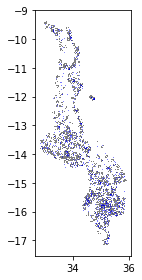

In [65]:
# Create plot
ax = image_geodf.plot(facecolor='grey')
outcome_geodf.plot(ax=ax, color='blue', markersize = .001, alpha = 0.2)
plt.tight_layout()

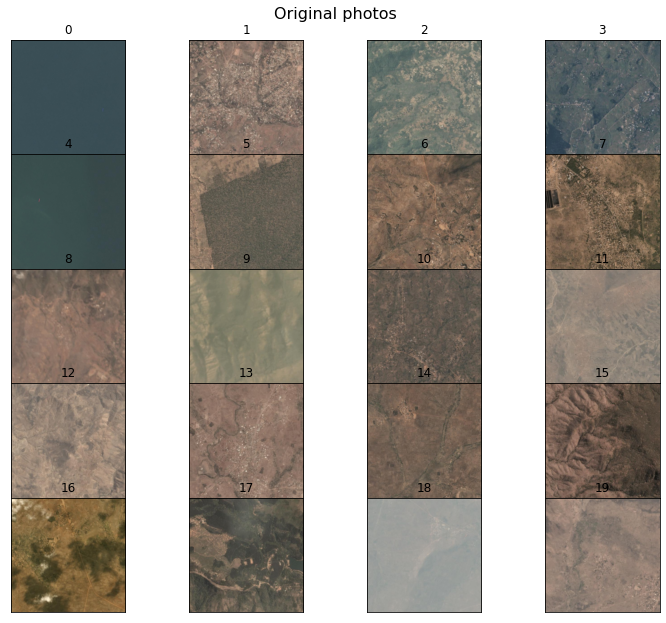

In [ ]:
### peak into the data

n_col = 5
n_row = 4
## show the original images
plt.figure(figsize=(2. * n_col, 2.26 * n_row))
plt.suptitle('Original photos', size=16)

#loop through some random images
for i, comp in enumerate(malawi_transform[:n_col*n_row]):
    plt.subplot(n_col, n_row, i + 1)
    #comp = scaler.inverse_transform(comp)
    comp = (comp * 255).astype(np.uint8)
    plt.imshow(comp.reshape(256,256,4))
    plt.title(i)
    plt.xticks(())
    plt.yticks(())
plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)

/Users/johannes/opt/anaconda3/lib/python3.8/site-packages/geopandas/plotting.py:123: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return PathPatch(path, **kwargs)


<AxesSubplot:>

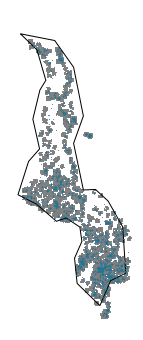

In [ ]:
#Create plot wiht Malawi outline
world = gpd.read_file(
    gpd.datasets.get_path('naturalearth_lowres'))
ax = geoplot.polyplot(image_geodf, color = 'grey')
geoplot.polyplot(world.query('name == "Malawi"'), ax = ax)
outcome_geodf.plot(markersize = 0.01, alpha = 0.2, ax = ax)

In [ ]:
## Check if two images are overlapping
np.asarray(geo_df["geometry"][1])[0].overlaps(np.asarray(geo_df["geometry"][302])[0])

True

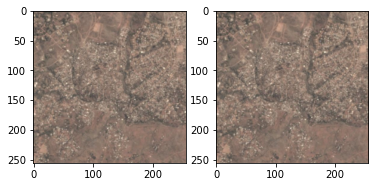

In [66]:
## Select a single image by it's ID to be printed
comp = malawi_transform[1]
#comp = scaler.inverse_transform(comp)
plt.figure()
plt.subplot(1, 2, 1)
comp = (comp * 255).astype(np.uint8)
plt.imshow(comp.reshape(256,256,4))

comp = malawi_transform[1784]
plt.subplot(1, 2, 2)
comp = (comp * 255).astype(np.uint8)
plt.imshow(comp.reshape(256,256,4))

In [ ]:
# remove duplicate images. 

print(raw_images_links[1])
print(raw_images_links[1784])


np.mean(np.asarray(Image.open(raw_images_links[1])) == np.asarray(Image.open(raw_images_links[1784])))

image_data/malawi_archive/images/-15.84688_35.071951921402_-15.84688_35.05698.png
image_data/malawi_archive/images/-15.843423764205975_35.080483842803986_-15.798507999999998_35.050540000000005.png


1.0

## Assemble Data Set

In [67]:
#make empty lists
X_full = []
Y_full = []
#fill them with the image data and the outcome data
for i in range(len(geo_df)):
    obs = geo_df.iloc[i]
    X_full.append(malawi_transform[int(obs['image_id'])])
    Y_full.append(obs['hv271'])

In [68]:
#split into train and test data set
X_train, X_test, y_train, y_test = train_test_split(X_full, Y_full, test_size=0.15)

## PCA

Haven't tried and will probably take forever to run but there is the code 

In [69]:
# Let's find how many components we should use by just applying a PCA with a range of components

#initialize the pca
pca = PCA(whiten=True, copy=True, random_state= 10)
#fit it
pca.fit(rd.sample(X_train,100))

#get the cumulative 
total = np.cumsum(pca.explained_variance_ratio_)

In [70]:
total[26]

0.8941914224445117

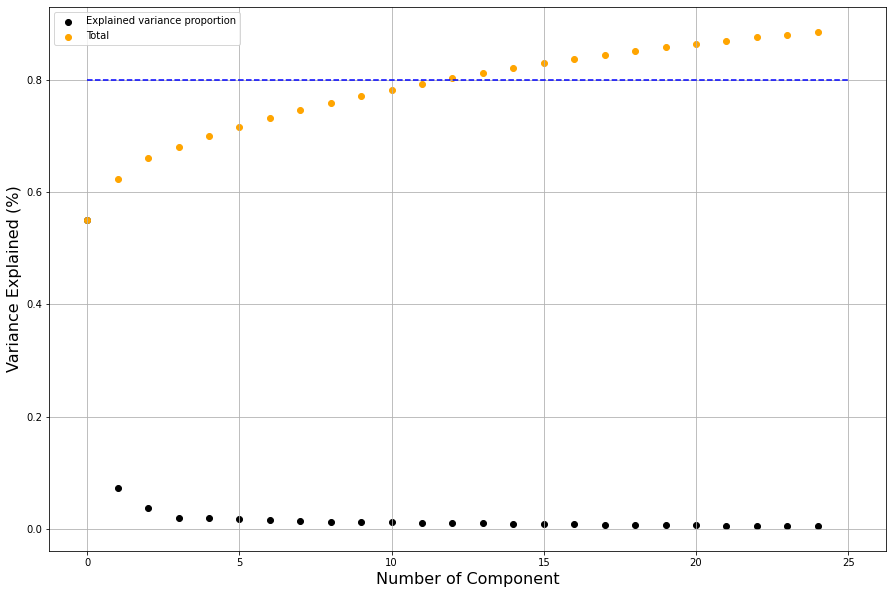

[0.54914845 0.07291299 0.03777005 0.0200076  0.01918092 0.01706716
 0.01565368 0.0134704  0.0128594  0.01199338 0.01153535 0.01114712
 0.00981422 0.00950598 0.00857156 0.00825446 0.00777899 0.00748984
 0.00708957 0.00657945 0.00595808 0.00563459 0.00555334 0.00502193
 0.00487837]


In [71]:
plt.figure(figsize=(15, 10))
comp_to_view = 25
#let's plot it
plot_xs = list(range(comp_to_view))


plt.scatter(plot_xs, pca.explained_variance_ratio_[:comp_to_view], color='black', label='Explained variance proportion')
plt.scatter(plot_xs, total[:comp_to_view],color='orange', label='Total')

plt.legend(loc=2)
plt.xlabel('Number of Component', size=16)
plt.ylabel('Variance Explained (%)', size=16)
plt.hlines(0.8,xmin=0, xmax=comp_to_view, colors = 'blue', linestyles='--')
plt.grid('minor')
plt.show()

print(pca.explained_variance_ratio_[:comp_to_view])

In [72]:
#initialize the pca
pca = PCA(n_components = 25, whiten=True, copy=True, random_state= 10)

#fit with random sample of 500 observations
pca.fit(rd.sample(X_train,1000))


PCA(n_components=25, random_state=10, whiten=True)

In [73]:
## batchwise transformation of the 

reduced = []
batchsize = 2500
# 
for i in range(0, len(X_train), batchsize):
    if i == 0:
        reduced = pca.transform(X_train[i:i+batchsize])
        continue 
    
    reduced_batch = pca.transform(X_train[i:i+batchsize])
    reduced = np.concatenate((reduced, reduced_batch), axis =0)


In [ ]:
# Ideas from Will
# Kernel Trick 
# Random Projection
# IRLS (iterarated reweighted)

In [77]:
X_train_pca = np.asarray(reduced)
len(X_train_pca)

13337

In [78]:
len(np.unique(X_train_pca))

11275

# Models

In [75]:
# linear regression with full un-PCAed data blows up the kernel
# 
lin_model = LinearRegression()
lin_model.fit(X_train_pca,y_train)

LinearRegression()

In [76]:
lin_model.score(X_train_pca, y_train)

0.06213885475934955

In [79]:
len(np.unique(X_train_pca))

11275

(array([2856., 4348., 2029., 1225.,  893.,  685.,  580.,  380.,  283.,
          58.]),
 array([-122719. ,  -70784.6,  -18850.2,   33084.2,   85018.6,  136953. ,
         188887.4,  240821.8,  292756.2,  344690.6,  396625. ]),
 <BarContainer object of 10 artists>)

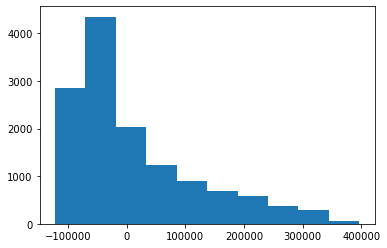

In [81]:
plt.hist((y_train))

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [82]:
hyper_n_list = [50,100,250,500]
hyper_depth_list = [None, 10, 20, 30, 40]
hyper_m_list = ["auto", "sqrt", "log2"]

In [83]:
rf = RandomForestRegressor(n_estimators= 100, bootstrap = True)
rf.fit(X_train_pca, y_train)

RandomForestRegressor()

In [84]:
rf.score(X_train_pca, y_train)

0.5327130213910282

## Running Grid Search on Random Forest Regressor

Tuning: 
- n_estimators: number of trees in the forest
- max_depth: maximum depth of the tree 
- max_features: number of features taken into account when splitting. 

In [ ]:
grid_search = GridSearchCV(RandomForestRegressor(random_state=0),
                           {
                              'n_estimators':[100],
                              'max_depth':[None, 10, 30],
                              'max_features': ["sqrt", "log2"]
                            },cv=2, scoring="r2",verbose=1,n_jobs=-1
                           )
grid_search.fit(X_train_pca,y_train)

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  12 | elapsed:    6.7s remaining:   33.7s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    8.6s finished


GridSearchCV(cv=2, estimator=RandomForestRegressor(random_state=0), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 30],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [100]},
             scoring='r2', verbose=1)

In [ ]:
cv_df = pd.DataFrame(grid_search.cv_results_)

In [ ]:
cv_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,5.008841,0.097852,0.383991,0.015103,None,sqrt,100,"{'max_depth': None, 'max_features': 'sqrt', 'n...",0.530587,0.527992,0.529289,0.001297,3
1,4.597774,0.010401,0.384221,0.010936,None,log2,100,"{'max_depth': None, 'max_features': 'log2', 'n...",0.530584,0.527992,0.529288,0.001296,4
2,4.286109,0.021608,0.253215,0.004534,10,sqrt,100,"{'max_depth': 10, 'max_features': 'sqrt', 'n_e...",0.489587,0.485202,0.487395,0.002193,5
3,3.706844,0.055501,0.236506,0.000505,10,log2,100,"{'max_depth': 10, 'max_features': 'log2', 'n_e...",0.489471,0.483308,0.486390,0.003081,6
4,4.404164,0.127968,0.238535,0.009679,30,sqrt,100,"{'max_depth': 30, 'max_features': 'sqrt', 'n_e...",0.530590,0.527993,0.529291,0.001299,2
5,3.660532,0.123937,0.236143,0.006631,30,log2,100,"{'max_depth': 30, 'max_features': 'log2', 'n_e...",0.530594,0.527996,0.529295,0.001299,1
